In [1]:
import torch
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from matplotlib import pyplot as plt  # Ensure this is imported at the top

In [180]:
def generate_classification_report(df, label_col='label', pred_col='prediction'):
    y_true = df[label_col]
    y_pred = df[pred_col]

    # 1. Classification report
    print("\n📊 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # 2. Confusion matrix
    print("\n🔍 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(set(y_true) | set(y_pred))
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    print(cm_df)

    # 3. Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 4. Explanation of metrics
    print("\n📘 Metric Explanations:")
    print("• Precision: Among all predicted as class X, how many are actually class X?")
    print("• Recall: Among all actual class X, how many were correctly predicted?")
    print("• F1-score: Harmonic mean of precision and recall (balance between both).")
    print("• Support: Number of true instances of each class in the dataset.")

    return report_df, cm_df


In [2]:
class ResNetEmbeddingModel(nn.Module):
	def __init__(self, resnet_version='ResNet18'):
		super(ResNetEmbeddingModel, self).__init__()
		
		# Choose ResNet version
		if resnet_version == 'ResNet18':
			self.backbone = models.resnet18(weights=None)  # No internet download
		elif resnet_version == 'ResNet34':
			self.backbone = models.resnet34(weights=None)
		else:
			raise ValueError("Unsupported ResNet version")

		# Remove final FC layer
		self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

	def forward(self, x):
		return self.backbone(x).squeeze()


In [25]:
class Predictor:
	"""
	Predictor class for computing similarity between two images using a ResNet embedding model.
	
	Args:
		resnet_version (str): Version of ResNet backbone to use ('ResNet18' or 'ResNet34').
		pretrained (bool): Whether to use pretrained weights (currently unused in your model).
		local_weight (str or None): Path to local checkpoint weights.
		device (str): Device to run the model on ('cpu' or 'cuda').
	"""
	
	def __init__(self, resnet_version='ResNet18', local_weight=None, distance_threshold=None, device="cpu"):
		# Initialize the embedding model with specified parameters
		
		self.model = ResNetEmbeddingModel(resnet_version=resnet_version)
		self.distance_threshold = distance_threshold
		self.device = device
		# Define preprocessing transforms to match model input requirements
		self.transform = transforms.Compose([
			transforms.Resize((224, 224)),  # Resize to model input size
			transforms.ToTensor(),		   # Convert PIL image to tensor
			transforms.Normalize(			# Normalize with ImageNet stats
				mean=[0.485, 0.456, 0.406], 
				std=[0.229, 0.224, 0.225]
			)
		])


		#Loading weights
		checkpoint = torch.load(local_weight, map_location=self.device, weights_only=False)	    
		self.model.load_state_dict(checkpoint['model_state_dict'])
		self.model.to(device)
		self.model.eval()

	    # Get threshold if not provided
		if distance_threshold is None:
			self.distance_threshold = checkpoint.get('distance_threshold', 1.0)
			print(f"Using trained distance threshold: {self.distance_threshold:.4f}")
	    
	
	def compute_distance(self, embedding1: torch.Tensor, embedding2: torch.Tensor) -> torch.Tensor:
		"""
		Compute the pairwise distance between two embeddings.
		
		Args:
			embedding1 (torch.Tensor): Embedding tensor of first image.
			embedding2 (torch.Tensor): Embedding tensor of second image.
		
		Returns:
			torch.Tensor: The pairwise distance between embeddings.
		"""
		return torch.nn.functional.pairwise_distance(embedding1, embedding2, p=2).item()

	# Load and process images
	def load_image(self, path):
		raw_img = Image.open(path).convert('RGB')
		return raw_img, self.transform(raw_img).unsqueeze(0).to(device)

	
	def get_similarity(self, genuine_img_path: str, doubted_img_path: str, display_images: bool = False) -> torch.Tensor:
		"""
		Calculate similarity (distance) between two images based on their embeddings.
	
		Args:
			genuine_img_path (str): File path to the genuine image.
			doubted_img_path (str): File path to the doubted image.
			display_images (bool): If True, display the two images side by side with titles.
	
		Returns:
			torch.Tensor: The distance score between the two image embeddings.
		"""
		# Load images and convert to RGB
		img1, img1_tensor = self.load_image(genuine_img_path)
		img2, img2_tensor = self.load_image(doubted_img_path)
		
		# Pass through model to get embeddings
		with torch.no_grad():
			emb1 = self.model(img1_tensor)
			emb2 = self.model(img2_tensor)
		
		# Compute similarity (distance)
		distance = self.compute_distance(emb1, emb2)
			
		# Determine if genuine (same person)
		is_genuine = distance < self.distance_threshold
	
		# Optionally display images with titles and similarity score
		if display_images:
			plt.figure(figsize=(8, 4))
			plt.suptitle(f"Similarity (Distance): {distance:.4f} - Label Genuine {is_genuine}", fontsize=14)
			plt.subplot(1, 2, 1)
			plt.title("Genuine")
			plt.axis("off")
			plt.imshow(img1)
			plt.subplot(1, 2, 2)
			plt.title("Doubted")
			plt.axis("off")
			plt.imshow(img2)
			plt.show()
		    
		    
		return is_genuine, distance


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model_name = "ResNet34"
local_weights_path = "../../model/models_checkpoints/resnet-34-v1/best_model.pth"
# Initialize model with local weights
predictor = Predictor(
	resnet_version=model_name,
	local_weight=local_weights_path,
	device= device
)


Using device: cuda
Using trained distance threshold: 5.0859


In [5]:
import pandas as pd
import random
import os

img_genuine_path : 0fa39728-2196-4311-8575-fe3aee2266a6.png
img_doubted_path : 79986c97-72e1-4bf1-976c-1d9937875e14.png
label : 0



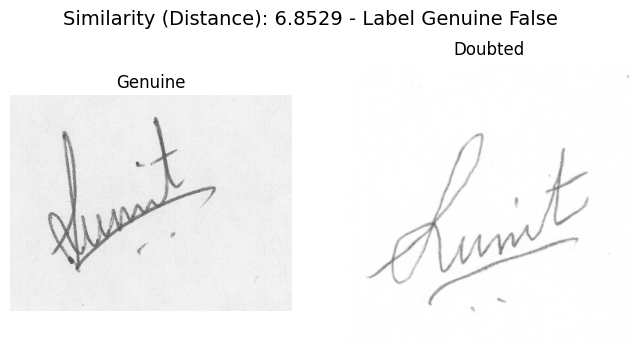

(False, 6.852903842926025)

In [177]:
folder_images = "../../data/classify/preprared_data/images/"
cpt = random.randint(0, len(df_test)-1)
row = df_test.values[cpt]

img_genuine_path = row[0]
img_doubted_path = row[1]
label = row[2]
print(f"""img_genuine_path : {img_genuine_path}
img_doubted_path : {img_doubted_path}
label : {label}
""")
predictor.get_similarity(os.path.join(folder_images,img_genuine_path),
						os.path.join(folder_images,img_doubted_path),
						 display_images=True
						)

In [6]:
df_test = pd.read_excel("../../data/classify/preprared_data/labels/test_pairs.xlsx")

In [178]:
df_test["prediction"] = [predictor.get_similarity(os.path.join(folder_images,row[0]),
						os.path.join(folder_images,row[1]),
						 display_images=False
						)[0] for row in df_test.values]

In [179]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


📊 Classification Report:
              precision    recall  f1-score      support
0              0.901954  0.804429  0.850405  6141.000000
1              0.664056  0.815527  0.732038  2911.000000
accuracy       0.807998  0.807998  0.807998     0.807998
macro avg      0.783005  0.809978  0.791221  9052.000000
weighted avg   0.825449  0.807998  0.812340  9052.000000

🔍 Confusion Matrix:
      0     1
0  4940  1201
1   537  2374


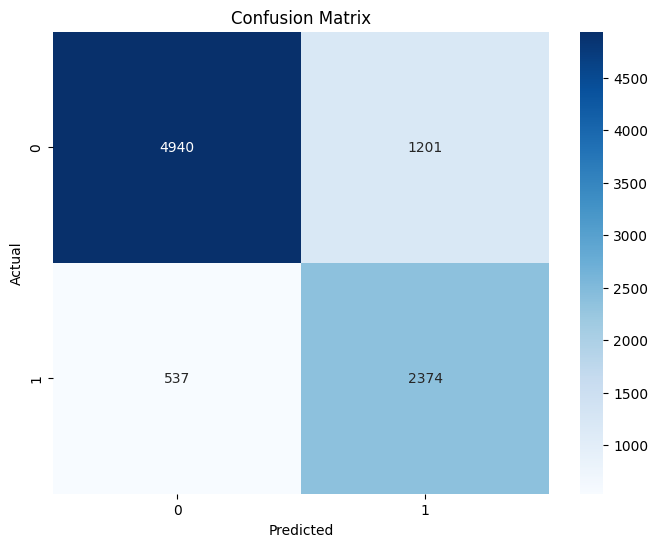


📘 Metric Explanations:
• Precision: Among all predicted as class X, how many are actually class X?
• Recall: Among all actual class X, how many were correctly predicted?
• F1-score: Harmonic mean of precision and recall (balance between both).
• Support: Number of true instances of each class in the dataset.


(              precision    recall  f1-score      support
 0              0.901954  0.804429  0.850405  6141.000000
 1              0.664056  0.815527  0.732038  2911.000000
 accuracy       0.807998  0.807998  0.807998     0.807998
 macro avg      0.783005  0.809978  0.791221  9052.000000
 weighted avg   0.825449  0.807998  0.812340  9052.000000,
       0     1
 0  4940  1201
 1   537  2374)

In [184]:
generate_classification_report(df_test, label_col='label', pred_col='prediction')

In [ ]:
df_test["prediction"]

In [142]:
img_doubted_path

'75c1ef1b-a2c3-404d-9578-3d476d7203e2.png'

In [19]:
df_test

image_1_path  \
0      fe8df58a-3e19-44c2-899f-f2fa299e20ac.png   
1      fe8df58a-3e19-44c2-899f-f2fa299e20ac.png   
2      fe8df58a-3e19-44c2-899f-f2fa299e20ac.png   
3      fe8df58a-3e19-44c2-899f-f2fa299e20ac.png   
4      fe8df58a-3e19-44c2-899f-f2fa299e20ac.png   
...                                         ...   
13568  e2a19373-80be-4299-b1f8-2a956805b65e.png   
13569  e2a19373-80be-4299-b1f8-2a956805b65e.png   
13570  e2a19373-80be-4299-b1f8-2a956805b65e.png   
13571  e2a19373-80be-4299-b1f8-2a956805b65e.png   
13572  e2a19373-80be-4299-b1f8-2a956805b65e.png   

                                   image_2_path  label  
0      afdb369c-1d37-4f50-8975-3056a804ac83.png      1  
1      f654e9c3-bca8-4ddf-b3a4-c5b9ce9a0391.png      1  
2      3ab7166b-d310-4add-abfc-f81ac655e655.png      1  
3      90289116-d20b-4549-b427-cd93ec5b7934.png      1  
4      88d13350-e120-461b-be76-38e3b640961e.png      1  
...                                         ...    ...  
13568  8ac8da82-1651-4d60-a2c9-92129cd9cba0.png      0  
13569  a3036049-b79b-4be9-9ec3-5117366f27c1.png      0  
13570  bfb0f988-df5f-4ab8-9953-7f0a20d67eb3.png      0  
13571  628655f4-c3e0-4619-b677-0e4c2f2dff36.png      0  
13572  c5000d04-3996-4c72-a833-d73f358e04c8.png      0  

[13573 rows x 3 columns]